In [ ]:
#|default_exp cielab

# Computing CIELAB values from RGB  

Extracting RGB values from the TIF image has been straight forward. Now we get to the gory details of color management. 

In [ ]:
# repeat extraction 
from colorchecker2cielab import extract_color_patches 

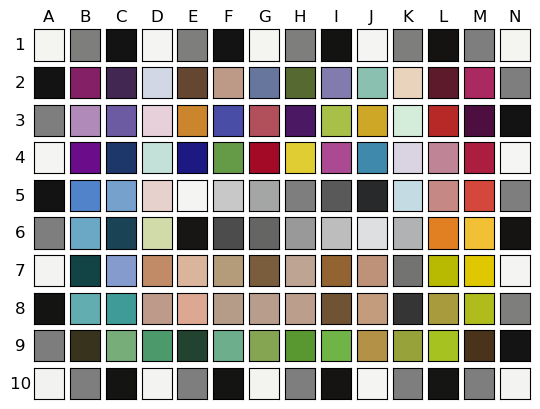

In [ ]:
tif_file = '/home/frank/Work/DATA/colorchecker2cielab-data/sk-C-1833_135MB.tif' 
rectangles, RGBs = extract_color_patches(tif_file)

While developing this python package I learned about several tricky details that I needed to grasp in order to compute accurate CIELAB color coordinates. These lessons learned are implemented in the `RGBs_to_LABs()` function as follows: 

``` {.python code-line-numbers="true"}
ECI_RGB_V2 = colour.models.RGB_COLOURSPACE_ECI_RGB_V2 
illuminant = ECI_RGB_V2.whitepoint # D50 
ECI_RGB_V2.use_derived_transformation_matrices = True 
XYZs = colour.RGB_to_XYZ(RGBs, ECI_RGB_V2, apply_cctf_decoding=True)
LABs = colour.XYZ_to_Lab(XYZs, illuminant=illuminant) 
```

Let's discuss these code lines one by one. Line 1 instantiates the `ECI RGB v2` color space whose properties (RGB primaries etc.) we need to calculate CIELAB color coordinates from RGB values. In line 2 we extract the chromaticity coordinates (x, y) for the D50 white point that we will need below. 

In line 3 we set the color space attribute `.use_derived_transformation_matrices` to `True`. This is related to the following issue described in the colour-science package [documentation](https://colour.readthedocs.io/en/develop/generated/colour.RGB_Colourspace.html):

>Colour science literature related to *RGB* colourspaces and encodings defines their dataset using different degree of precision or rounding. While instances where a whitepoint is being defined with a value different from its canonical agreed one are rare, it is however very common to have normalised primary matrices **rounded at different decimals**. This can yield **large discrepancies in computations.*** 

The default for this option is False. We will want to maximize the precision, therefore we explicitly need to set this attribute to True. 

In line 4 we first calculate the CIE XYZ tristimulus color coordinates with the `RGB_to_XYZ()` function. To do this correctly we need to set the `apply_cctf_decoding` option to `True` because the non-linear RGB coordinates in the TIFF need to be decoded (=linearized) as a first step. This is is done with the `CIE L*` luminance function as prescribed by the ECI RGB v2 color model. 

In line 5 we convert the XYZ tristimulus values into CIELAB coordinates with the `XYZ_to_Lab()` function. The default illuminant for the function is D65. Therefore we explicitly need to set the illuminant option to the D50 white point. I now understand that CIELAB coordinates are defined relative to a white point!  


In [ ]:
from colorchecker2cielab import RGBs_to_LABs, read_target_data, compute_deltaEs

In [ ]:
target_txt_file = '/home/frank/Work/DATA/colorchecker2cielab-data/AG_003_20221230_2.txt' 

tif_LABs = RGBs_to_LABs(RGBs)
target_LABS = read_target_data(target_txt_file)  

In [ ]:
both = compute_deltaEs(target_LABS, tif_LABs)
print(both.to_string())

     ref_L*  ref_a*  ref_b*    L*     a*     b*  dE_2000  dE_1976
A1    95.35   -0.75    2.56 95.56  -0.76   2.22     0.33     0.40
B1    49.51   -0.53    0.38 49.37  -0.39   0.36     0.24     0.20
C1     8.59    0.26   -0.70  7.72   0.42   0.26     1.11     1.30
D1    95.62   -0.80    2.35 95.96  -0.89   1.92     0.46     0.55
E1    49.53   -0.54    0.41 49.36  -0.41   0.37     0.26     0.22
F1     8.47    0.16   -0.86  7.41   0.45   0.24     1.34     1.56
G1    95.50   -0.82    2.40 95.85  -0.95   1.88     0.56     0.64
H1    49.53   -0.54    0.44 49.37  -0.44   0.34     0.24     0.22
I1     8.44    0.27   -0.82  7.38   0.17   0.26     1.26     1.52
J1    95.63   -0.81    2.34 95.91  -0.92   1.84     0.52     0.59
K1    49.46   -0.55    0.34 49.38  -0.42   0.28     0.21     0.16
L1     9.55    0.36   -0.45  7.58   0.50   0.63     1.63     2.25
M1    49.37   -0.53    0.33 49.43  -0.45   0.21     0.18     0.16
N1    95.34   -0.80    2.46 95.71  -0.90   1.94     0.55     0.64
A2     9.0

In [ ]:
#|export 

import colour 
import pandas as pd
import numpy as np 

In [ ]:
#|export 

def read_target_data(target_txt_file, verbose=False): 
    '''Read measured CIELAB values from text file for specific Colorchecker target. '''
    
    # just print the contents of the target data file...  
    if verbose: 
        with open(target_txt_file, 'r') as fh: 
            lines = fh.readlines()    
        for l in lines: 
            print(l, end='') 

    # TODO: make more robust for other file formats 
    target_df = pd.read_csv(target_txt_file, skiprows=22, delimiter='\t', decimal=',', nrows=140, 
                     usecols=[1, 2, 3, 4], names=['Name', 'ref_L*', 'ref_a*', 'ref_b*'])
    target_df.set_index('Name', inplace=True) 
    target_df.index.name = None 

    return target_df 


def RGBs_to_LABs(RGBs, use_derived_transformation_matrices=True): 
    '''Convert RGB values dataframe into CIELAB values dataframe assuming ECI_RGB_v2 colour space. 
    
    If the option `use_derived_transformation_matrices`is true (default) then high precision matrices 
    are used for the computation. If set to false, matrices values as described in the standards are used.'''

    # dataframe to array 
    index = RGBs.index 
    RGBs = RGBs.values

    
    # conversion of RGB to CIELAB 
    ECI_RGB_V2 = colour.models.RGB_COLOURSPACE_ECI_RGB_V2
    ECI_RGB_V2.use_derived_transformation_matrices = use_derived_transformation_matrices 
    illuminant = ECI_RGB_V2.whitepoint # D50 

    XYZs = colour.RGB_to_XYZ(RGBs, ECI_RGB_V2, apply_cctf_decoding=True)
    LABs = colour.XYZ_to_Lab(XYZs, illuminant=illuminant) 

    # array to dataframe 
    pd.options.display.float_format = '{:,.2f}'.format 
    LAB_df = pd.DataFrame(LABs, index=index, columns=['L*', 'a*', 'b*'])

    return LAB_df


def compute_deltaEs(target_LABs, tif_LABs):
    '''Computes color differences according to CIE2000 and CIE1976. '''

    # set global display options 
    #pd.options.display.precision = 2
    pd.options.display.float_format = '{:,.2f}'.format 
    both = pd.concat([target_LABs, tif_LABs], axis=1)

    dE_2000 = colour.delta_E(target_LABs.values, tif_LABs.values, method='CIE 2000') #, 'CIE 1994', 'CIE 2000') 
    dE_1976 = colour.delta_E(target_LABs.values, tif_LABs.values, method='CIE 1976') #, 'CIE 1994', 'CIE 2000')
    
    both['dE_2000'] = dE_2000
    both['dE_1976'] = dE_1976
    
    
    return both    